# 3 Approaches to the project
1. In our first approach, we coded a basic neural network from scratch using NumPy. We did this so that we can understand all the computations that are done during forward and backward propagation and learn how to implement those computations in code.
2. In our second approach we used keras built on top of tensorflow to create the same model as the first one and train it on the same dataset. We have also used **Genetic Algorithm to optimise some of the parameters of the model**.
3. Dissatisfied with the results of the first dataset, we used a higher quality dataset in the third approach to train the neural networks built in the first two approaches and see how they perform.

# Setup
Firstly, we will need to import the necessary libraries to pre-process the data and create a neural network model. We will code a neural network from scratch using NumPy in our first approach. For the second approach we will be using keras built on top of tensorflow to create a model with the same architecture. For the third approach we will test our tensorflow model on another dataset.

In [1]:
import tensorflow as tf
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from keras.utils import plot_model
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Set seed for NumPy
np.random.seed(42)
# Set seed for TensorFlow
tf.random.set_seed(42)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/heart-failure-prediction/heart.csv
/kaggle/input/heart-attack-prediction-dataset/heart_attack_prediction_dataset.csv
/kaggle/input/heart-failure-prediction/heart.csv
/kaggle/input/heart-attack-prediction-dataset/heart_attack_prediction_dataset.csv


# Importing the dataset and looking at the first five rows
> We will use the pandas library to import the training data and store it in the 'file' variable as a pandas DataFrame.

In [2]:
file = pd.read_csv("/kaggle/input/heart-attack-prediction-dataset/heart_attack_prediction_dataset.csv")
file.head()

,Patient ID,Age,Sex,Cholesterol,Blood Pressure,Heart Rate,Diabetes,Family History,Smoking,Obesity,...,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent,Hemisphere,Heart Attack Risk
0,BMW7812,67,Male,208,158/88,72,0,0,1,0,...,6.615001,261404,31.251233,286,0,6,Argentina,South America,Southern Hemisphere,0
1,CZE1114,21,Male,389,165/93,98,1,1,1,1,...,4.963459,285768,27.194973,235,1,7,Canada,North America,Northern Hemisphere,0
2,BNI9906,21,Female,324,174/99,72,1,0,0,0,...,9.463426,235282,28.176571,587,4,4,France,Europe,Northern Hemisphere,0
3,JLN3497,84,Male,383,163/100,73,1,1,1,0,...,7.648981,125640,36.464704,378,3,4,Canada,North America,Northern Hemisphere,0
4,GFO8847,66,Male,318,91/88,93,1,1,1,1,...,1.514821,160555,21.809144,231,1,5,Thailand,Asia,Northern Hemisphere,0


# Setting the Objective
As we can see from the data, it provides us with different features of a patient and in the last column it indicates whether the person has a risk of heart attack using 0 or 1. Thus, we will treat this as a **Binary Classification** problem by building the model to predict whether a person has a risk of heart attack or not. The output of the model will be 0 or 1 instead of a probability.

# Data Pre-Processing
Before the data can be fed into our model to train, the data needs to be processed. Irrelevant features will be removed and categorical features will be OneHotEncoded.

> First, we use file.shape to determine the number of rows and columns in the data.

In [3]:
file.shape

(8763, 26)

>  The shape of the dataframe is (8763, 26), which means there's 8763 patients and 26 features (columns) per patient. We will look at the columns in the dataframe and select the suitable ones for training.

In [4]:
file.columns #outputs the column names

Index(['Patient ID', 'Age', 'Sex', 'Cholesterol', 'Blood Pressure',
       'Heart Rate', 'Diabetes', 'Family History', 'Smoking', 'Obesity',
       'Alcohol Consumption', 'Exercise Hours Per Week', 'Diet',
       'Previous Heart Problems', 'Medication Use', 'Stress Level',
       'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides',
       'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Country',
       'Continent', 'Hemisphere', 'Heart Attack Risk'],
      dtype='object')

* Features such as Patient ID, Income, Continent, Hemisphere, Country are unlikely factors that contribute to the risk of heart attack, thus we will drop these columns from the dataframe; these features will not be considered when training the data and predicting the risk of heart attack.
* We will also drop the "Heart Attack Risk" column as this is our target column. We will store the dataframe with the dropped columns in the variable 'x' which will be the input to the neural network.
* The target column will be stored in the variable 'y' which the model will use to calculate error. Thus, y will be an array with only 1 column and 8763 rows.

In [5]:
x = file.drop(["Patient ID", "Income","Continent","Hemisphere","Heart Attack Risk", "Country"],axis=1)
y = file['Heart Attack Risk']

In [6]:
print("Shape of y: ", y.shape)
y.head()

Shape of y:  (8763,)


0    0
1    0
2    0
3    0
4    0
Name: Heart Attack Risk, dtype: int64

# OneHotEncoding and converting non-numerical data into numerical data
* The columns Diet and Sex contain non-numerical values, thus these cannot be fed directly into the neural network as the network will not be able to do any mathematical operations on them. We will one-hot encode the 'Diet' and 'Sex' columns. One-hot encoding is a technique used to convert categorical variables into a binary matrix format, where each category is represented by a binary vector. For example, in the 'Diet' column, 'healthy' might be represented as [1, 0, 0], 'unhealthy' as [0, 1, 0], and 'average' as [0, 0, 1]. Similarly, in the 'Sex' column, 'male' might be represented as [1, 0] and 'female' as [0, 1]. This transformation allows the neural network to effectively process categorical data by treating each category as a separate binary feature, enabling it to learn relationships between the categories and the target variable.
* The blood pressure column is given as a string in the format Systolic/Diastolic. We will create seperate columns for Systolic and Diastolic that contains the integer value. As we created the two new columns, the 'Blood Pressure' column will not be required anymore so we will drop it.

In [7]:
#OneHotEncoding Diet and Sex

x = pd.get_dummies(x, columns=["Diet","Sex"],prefix=["Diet","Sex"])

#Seperating the Systolic and Diastolic Blood Pressure and dropping the Blood Pressure column

x[["Systolic","Diastolic"]] = x["Blood Pressure"].str.split('/', expand=True)
x[['Systolic', 'Diastolic']] = x[['Systolic', 'Diastolic']].apply(pd.to_numeric)
x = x.drop('Blood Pressure', axis=1)

> Now the data has been processed as required. All irrelevant columns have been dropped and all non-numeric values have been converted into numeric values. We can see the processed data below along with it's new shape. It still has 8763 rows but the number of columns have changed since we dropped a few and created a few through OneHotEncoding.

In [8]:
print("Shape: ", x.shape)
x.head()

Shape:  (8763, 24)


,Age,Cholesterol,Heart Rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Previous Heart Problems,...,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Diet_Average,Diet_Healthy,Diet_Unhealthy,Sex_Female,Sex_Male,Systolic,Diastolic
0,67,208,72,0,0,1,0,0,4.168189,0,...,286,0,6,True,False,False,False,True,158,88
1,21,389,98,1,1,1,1,1,1.813242,1,...,235,1,7,False,False,True,False,True,165,93
2,21,324,72,1,0,0,0,0,2.078353,1,...,587,4,4,False,True,False,True,False,174,99
3,84,383,73,1,1,1,0,1,9.828130,1,...,378,3,4,True,False,False,False,True,163,100
4,66,318,93,1,1,1,1,0,5.804299,1,...,231,1,5,False,False,True,False,True,91,88


# Normalisation
> There is one last step remaining in pre-processing the data before we can feed it into the neural network. Since the columns have a range of different values, we will carry out normalisation to improve gradient descent. In this step, the data will also be converted from a DataFrame to a numpy array so that it can be easily fed into the neural network.

In [9]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
x=scaler.fit_transform(x)
x

array([[ 6.25557131e-01, -6.41578894e-01, -1.47042098e-01, ...,
         6.58765153e-01,  8.70044389e-01,  1.93781814e-01],
       [-1.53932232e+00,  1.59689495e+00,  1.11817855e+00, ...,
         6.58765153e-01,  1.13571444e+00,  5.34480428e-01],
       [-1.53932232e+00,  7.93023127e-01, -1.47042098e-01, ...,
        -1.51799165e+00,  1.47729021e+00,  9.43318765e-01],
       ...,
       [-3.15694803e-01, -1.22154025e-01,  1.45881488e+00, ...,
         6.58765153e-01,  9.83902981e-01, -6.92034583e-01],
       [-8.33383367e-01, -1.01259666e+00, -7.30990089e-01, ...,
         6.58765153e-01, -6.10117296e-01, -1.23715237e+00],
       [-1.35107193e+00,  1.18877541e+00, -1.05510022e-03, ...,
        -1.51799165e+00,  1.10987115e-01, -1.23715237e+00]])

# Creating a training set and validation set
* Since we want our model to generalise, we will be splitting the data into a train set and validation set. The validation set will comprise of 20% of the original data and the rest of the 80% of the data will be used for training. Once training is done using the training set, we can use the validation set to see how well our model has generalised.

In [10]:
from sklearn.model_selection import train_test_split
random_seed = 42 #to get consistent results
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = random_seed)

#Adjusting the shape of y
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)
y_test.shape

(1753, 1)

# First Approach - Coding a Neural Network from Scratch
* Below is the code for the neural network we coded using numpy. The code is divided into several functions for each step which are compiled together in **L_layer_model(X, Y, layers_dims, learning_rate=0.01, num_iterations=30, print_cost=True)** to create a functional model. The model is hard-coded to have **ReLU activation in the hidden layers and Sigmoid activation** in the output layer. The loss is computed using the **compute_cost()** function which computes the loss using **Binary Crossentropy** since we are trying to predict **True** or **False** instead of a probability. The description of each function is given as a comment under the respective function.

Here is an overview of the functions that are used to built the neural network.
>* **relu**: Computes the ReLU.
>* **relu_backward**: Implements the backward propagation for a single ReLU unit.
>* **sigmoid_backward**: Implements the backward propagation for a single sigmoid unit.
>* **initialize_parameters_deep**: Initializes the parameters of a deep neural network.
>* **linear_forward**: Implements the linear part of a layer's forward propagation.
>* **linear_activation_forward**: Implements the forward propagation for the linear -> activation.
>* **L_model_forward**: Implements forward propagation for the entire network.
>* **compute_cost**: Computes the cost function (cross-entropy cost).
>* **linear_backward**: Implements the linear portion of backward propagation for a single layer.
>* **linear_activation_backward**: Implements the backward propagation for the linear -> activation.
>* **L_model_backward**: Implements the backward propagation for the entire network.
>* **update_parameters**: Updates parameters using gradient descent.
>* **L_layer_model**: Implements a L-layer neural network. L is the number of layers defined by the user.
>* **predict**: Predicts the results of a L-layer neural network.
>* **plot_costs**: Plots the learning curve.
 

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import copy

def sigmoid(Z):
    """
    Compute the sigmoid activation function element-wise.

    Arguments:
    Z -- numpy array of any shape

    Returns:
    A -- output of the sigmoid function, same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    A = 1 / (1 + np.exp(-Z))
    cache = Z
    return A, cache

def relu(Z):
    """
    Compute the ReLU activation function element-wise.

    Arguments:
    Z -- Output of the linear layer, of any shape

    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    A = np.maximum(0, Z)
    assert (A.shape == Z.shape)
    cache = Z
    return A, cache

def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    assert (dZ.shape == Z.shape)
    return dZ

def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    Z = cache
    s = 1 / (1 + np.exp(-Z))
    dZ = dA * s * (1 - s)
    assert (dZ.shape == Z.shape)
    return dZ

def initialize_parameters_deep(layer_dims):
    """
    Initialize the parameters of the deep neural network.

    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network

    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        assert (parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert (parameters['b' + str(l)].shape == (layer_dims[l], 1))
    return parameters

def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter
    cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    Z = W.dot(A) + b
    cache = (A, W, b)
    return Z, cache

def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value
    cache -- a python tuple containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    cache = (linear_cache, activation_cache)
    return A, cache

def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation

    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()

    Returns:
    AL -- activation value from the output (last) layer
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L of them, indexed from 0 to L-1)
    """
    caches = []
    A = X
    L = len(parameters) // 2
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], "relu")
        caches.append(cache)
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], "sigmoid")
    caches.append(cache)
    return AL, caches

def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    m = Y.shape[1]
    cost = -np.sum(np.multiply(np.log(AL), Y) + np.multiply(np.log(1 - AL), (1 - Y))) / m
    cost = np.squeeze(cost)
    return cost

def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = np.dot(dZ, A_prev.T) / m
    db = (np.sum(dZ, axis=1, keepdims=True)) / m
    dA_prev = np.dot(W.T, dZ)
    return dA_prev, dW, db

def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.

    Arguments:
    dA -- post-activation gradient for current layer l
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    return dA_prev, dW, db

def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group

    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])

    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ...
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ...
    """
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    current_cache = caches[L - 1]
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dAL, current_cache, "sigmoid")
    grads["dA" + str(L - 1)] = dA_prev_temp
    grads["dW" + str(L)] = dW_temp
    grads["db" + str(L)] = db_temp
    for l in reversed(range(L - 1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
    return grads

def update_parameters(params, grads, learning_rate):
    """
    Update parameters using gradient descent

    Arguments:
    params -- python dictionary containing your parameters
    grads -- python dictionary containing your gradients, output of L_model_backward

    Returns:
    parameters -- python dictionary containing your updated parameters
                  parameters["W" + str(l)] = ...
                  parameters["b" + str(l)] = ...
    """
    parameters = copy.deepcopy(params)
    L = len(parameters) // 2
    for l in range(L):
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * grads["db" + str(l + 1)]
    return parameters

def L_layer_model(X, Y, layers_dims, learning_rate=0.01, num_iterations=30, print_cost=True):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.

    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 5 steps

    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    np.random.seed(1)
    costs = []  # keep track of cost
    parameters = initialize_parameters_deep(layers_dims)
    for i in range(0, num_iterations):
        AL, caches = L_model_forward(X, parameters)
        cost = compute_cost(AL, Y)
        grads = L_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)
    return parameters, costs

def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.

    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model

    Returns:
    p -- predictions for the given dataset X
    """
    m = X.shape[1]
    n = len(parameters) // 2
    p = np.zeros((1, m))
    probas, caches = L_model_forward(X, parameters)
    for i in range(0, probas.shape[1]):
        if probas[0, i] > 0.5:
            p[0, i] = 1
        else:
            p[0, i] = 0
    print("Accuracy: " + str(np.sum((p == y) / m)))
    return p

def plot_costs(costs, learning_rate=0.0075):
    """
    Plot the learning curve.

    Arguments:
    costs -- list of costs
    learning_rate -- learning rate used during training
    """
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()


# Creating the Neural Network Architecture
* We are going to use Dense layers, which means all the neurons in a layer will be connected to all the neurons in the previous layer. 
* Using the neural network coded in the previous cell, we can build a custom model by specifying the number of layers and the neurons per layer. This is done in the **layer_dims** list in the following code cell.
* Building a model is an iterative process, it is difficult to built the optimum model in the first try. For our baseline model we will use 5 layers (including the input and output layer). The **input layer consists of 24 nodes as there are 24 features**. The **3 hidden layers contain 32, 16 and 8 neurons respectively**. The **output layer contains only 1 neuron**. The architecture strikes a balance between model complexity and capacity. With 5 layers, the network has the capacity to learn intricate patterns and relationships within the data. However, it's not overly complex, which could lead to overfitting, especially in scenarios where the dataset is not sufficiently large.
* The input layer has no activation function. The **hidden layers compute ReLU activation** as it will increase the rate of gradient descent and the **output layer computes a sigmoid activation** since it is the best choice for binary classification. 


In [12]:
### Layers ###
layers_dims = [24, 32, 16, 8, 1] #Specify the number of neurons in each layer

Below is the visual represenation of our neural network.

![Neural Network Architecture](https://svgshare.com/i/133N.svg)

# Training the model
> After we're done with creating the architecture for the neural network, we can train the model using model.compile.
* The learning rate is set to a low value of **0.01**
* The **loss** is calculated using **BinaryCrossentropy()**
* The network is trained for **1000 epochs**
* The learned parameters *(updated weights and biases)* from the training is stored in the **parameters** variable


A graph plot is produced to observe the cost against the epochs. 

Cost after iteration 0: 0.6931472024014913
Cost after iteration 100: 0.6773066895726916
Cost after iteration 200: 0.6676857039133842
Cost after iteration 300: 0.6618185462939213
Cost after iteration 400: 0.6582232688049151
Cost after iteration 500: 0.6560096455468513
Cost after iteration 600: 0.654640822241673
Cost after iteration 700: 0.6537912266471969
Cost after iteration 800: 0.6532622416640248
Cost after iteration 900: 0.6529320195290441
Cost after iteration 999: 0.6527270598939531


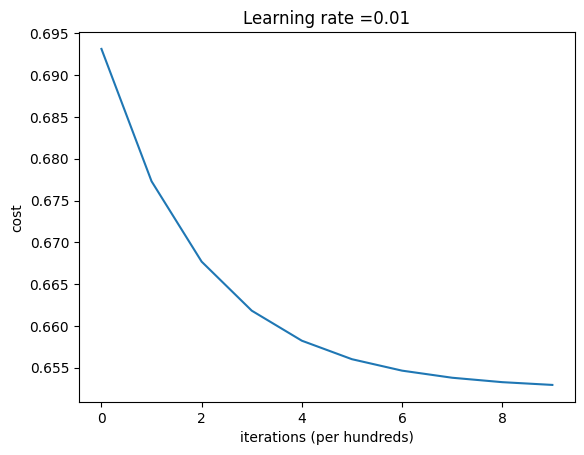

In [13]:
#Train the model
parameters, costs = L_layer_model(x_train.T, y_train.T, layers_dims, num_iterations = 1000, print_cost = True, learning_rate=0.01)
#Plot the graph of cost against iteration
plot_costs(costs, learning_rate=0.01)

# Predicting with the model

We are going to use the learned parameters of the model to predict from both the training set and test set 

In [14]:
#predicting on the train set
predictions_train = predict(x_train.T, y_train.T, parameters)
#predicting on the test set
predictions_test = predict(x_test.T, y_test.T, parameters)

Accuracy: 0.6417974322396576
Accuracy: 0.6417569880205363


# Analysing the model
The accuracy on both the training set and the test set is similar. The model isn't overfitting to the training set but it is also not generalising properly. We are not using any momentum optimisation, thus the loss may haven gotten stuck in a local minima which is why it is not overfitting even after 1000 epochs.

# Possible reasons for low accuracy
> The low accuracy can be due to a number of reasons. Firstly, it can be due to a bad model with suboptimal hyperparameters or due to incorrect feature selection. However, in this case, the most likely reason for the low accuracy is because of the data. According to the publisher of the data, the dataset is a synthetic dataset generated using ChatGPT. Given this, it's understandable that the data may not faithfully represent real-world scenarios or exhibit meaningful patterns. Therefore, it's conceivable that the output accuracy is hindered by the inherent limitations of the dataset quality, adhering to the principle of ***garbage in, garbage out.***

# Second Approach - Building a Model Using Tensorflow Keras
In our first approach we built a neural network from scratch to understand how to implement the computations in code. In the second approach, we are going to use Keras on top of tensorflow to train the model on the same dataset. We are opting for a Keras model because it comes in-built with optimisations that will help us run the model faster. It will also allow us to easily tune the hyperparameters using Genetic Algorithm.

# Building the Tensorflow Model
As we are going to use the same dataset from the previous approach, there is no further need to pre-process the data; we can jump straight to building the Keras model.
> We are using Keras to build our neural network model since it allows us to easily create the neural network architecture without having to do any math. Using Keras, we can simply just add a layer using Dense() and specify the number of neurons in the layer and the activation function. The architecture of this network will be the same as the first approach.
* We are going to use Dense layers, which means all the layers will be connected to all the neurons in the previous layer.
* We will use 5 layers (including the input and output layer). The **input layer consists of 24 nodes as there are 24 features**. The **3 hidden layers contain 32, 16 and 8 neurons respectively**. The **output layer contains only 1 neuron**. (The same baseline model as the previous approach)
* The input layer has no activation function. The **hidden layers compute ReLU activation** and the **output layer computes a sigmoid activation** since it is the best choice for binary classification.


In [15]:
n = x.shape[1] #number of features

#Creating the neural network model
model = Sequential([
    tf.keras.Input(shape=(n,), name="input_layer"), #Input Layer with 'n' neurons
    Dense(units=32, activation="relu", name="hidden_layer1"),
    Dense(units=16, activation="relu", name="hidden_layer2"),
    Dense(units=8, activation="relu", name="hidden_layer3"),
    Dense(units=1, activation="sigmoid", name="output_layer"),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer1 (Dense)       (None, 32)                800       
                                                                 
 hidden_layer2 (Dense)       (None, 16)                528       
                                                                 
 hidden_layer3 (Dense)       (None, 8)                 136       
                                                                 
 output_layer (Dense)        (None, 1)                 9         
                                                                 
Total params: 1473 (5.75 KB)
Trainable params: 1473 (5.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Training the model
> After we're done with creating the architecture for the neural network, we can train the model using model.compile.
* We're using the **Adam optimisation** algorithm which makes use of **momentum** and **RMSProp** to smooth out the gradient descent.
* The learning rate is set to a low value of **0.01**
* The **loss** is calculated using **BinaryCrossentropy()**
* The network is trained for **250 epochs** with a **batch size = dataset size**

In [16]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), loss = tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size = x_train.shape[0], epochs = 250, validation_data=(x_test, y_test))

Epoch 1/250
1/1 [==============================] - 3s 3s/step - loss: 0.8291 - accuracy: 0.4030 - val_loss: 0.7120 - val_accuracy: 0.5248
Epoch 2/250
1/1 [==============================] - 0s 30ms/step - loss: 0.7084 - accuracy: 0.5245 - val_loss: 0.6743 - val_accuracy: 0.6127
Epoch 3/250
1/1 [==============================] - 0s 31ms/step - loss: 0.6713 - accuracy: 0.6155 - val_loss: 0.6734 - val_accuracy: 0.6395
Epoch 4/250
1/1 [==============================] - 0s 31ms/step - loss: 0.6716 - accuracy: 0.6395 - val_loss: 0.6752 - val_accuracy: 0.6406
Epoch 5/250
1/1 [==============================] - 0s 30ms/step - loss: 0.6732 - accuracy: 0.6418 - val_loss: 0.6706 - val_accuracy: 0.6418
Epoch 6/250
1/1 [==============================] - 0s 32ms/step - loss: 0.6683 - accuracy: 0.6418 - val_loss: 0.6636 - val_accuracy: 0.6418
Epoch 7/250
1/1 [==============================] - 0s 30ms/step - loss: 0.6610 - accuracy: 0.6418 - val_loss: 0.6585 - val_accuracy: 0.6418
Epoch 8/250
1/1 [=====

# Analysing the model
We can analyse how well our tensorflow model performs by looking at the loss and accuracy plotted against epoch. As we can see from the graphs below, the accuracy when the model predicts from data it has already been trained on (the training set) increases per epoch. However, when the model sees new data (validation set) the accuracy decreases per epoch.

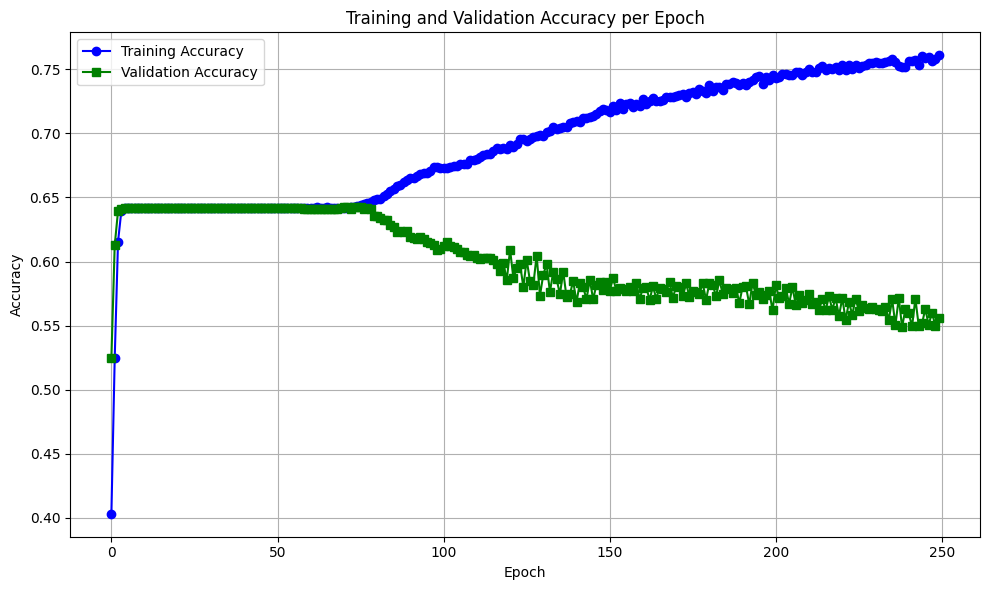

In [17]:
import matplotlib.pyplot as plt
val_acc = history.history['val_accuracy']  # Assuming the metric is named 'val_accuracy'
plt.figure(figsize=(10, 6))

# Plot training accuracy
plt.plot(range(len(history.history['accuracy'])), history.history['accuracy'], label='Training Accuracy', marker='o', color='b')

# Plot validation accuracy
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy', marker='s', color='g')

# Add labels, title, legend, grid, etc.
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

From the graph under the code cell below, we can see the Loss for the training set decreases per epoch, but the loss for validation increases per epoch.

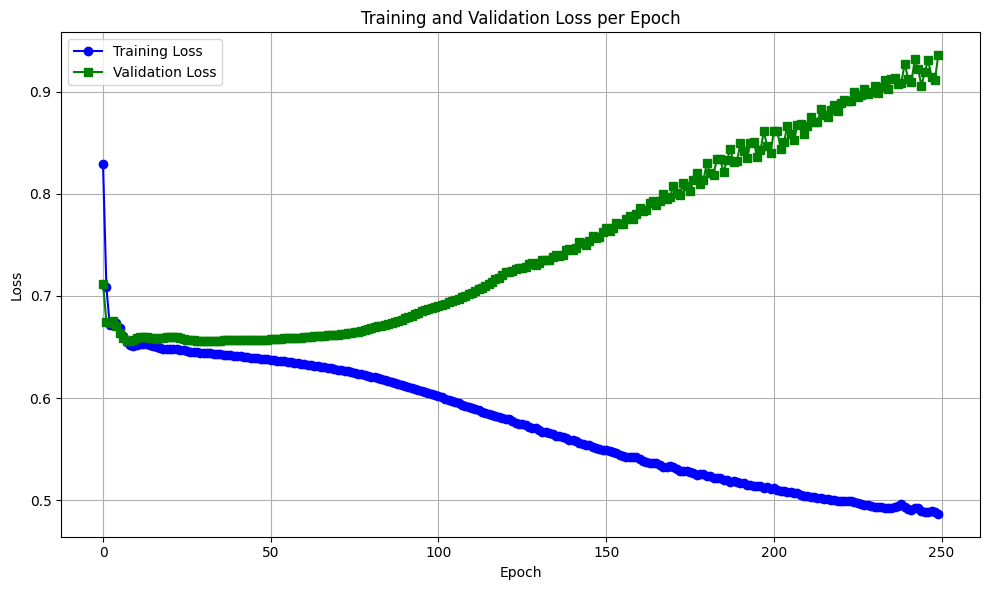

In [18]:
import matplotlib.pyplot as plt
val_acc = history.history['val_loss']
plt.figure(figsize=(10, 6))

# Plot training accuracy
plt.plot(range(len(history.history['loss'])), history.history['loss'], label='Training Loss', marker='o', color='b')
# Plot validation accuracy
plt.plot(range(len(val_acc)), val_acc, label='Validation Loss', marker='s', color='g')

# Add labels, title, legend, grid, etc.
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Below we have the classification report when the model predicts from the training set.

In [19]:
# Apply threshold for binary predictions
a = x_train
b = y_train
predictions = model.predict(a)
threshold = 0.5
binary_predictions = (predictions >= threshold).astype(int)

# Evaluate and print results
accuracy = accuracy_score(b, binary_predictions)
conf_matrix = confusion_matrix(b, binary_predictions)
class_report = classification_report(b, binary_predictions)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(class_report)

220/220 [==============================] - 0s 1ms/step
Accuracy: 0.7601997146932953
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.87      0.82      4499
           1       0.71      0.56      0.63      2511

    accuracy                           0.76      7010
   macro avg       0.74      0.72      0.72      7010
weighted avg       0.75      0.76      0.75      7010



Below we have the classification report when the model predicts from the test set.

In [20]:
# Apply threshold for binary predictions
a = x_test
b = y_test
predictions = model.predict(a)
threshold = 0.5
binary_predictions = (predictions >= threshold).astype(int)

# Evaluate and print results
accuracy = accuracy_score(b, binary_predictions)
conf_matrix = confusion_matrix(b, binary_predictions)
class_report = classification_report(b, binary_predictions)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(class_report)

55/55 [==============================] - 0s 1ms/step
Accuracy: 0.5556189389617798
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.71      0.67      1125
           1       0.35      0.27      0.30       628

    accuracy                           0.56      1753
   macro avg       0.49      0.49      0.49      1753
weighted avg       0.53      0.56      0.54      1753



As we can see from the accuracy against epochs graph, the tensorflow model performs the same on the validation set as the neural network coded from scratch until about 30 epochs. From this we can conclude that the calculations within our coded neural network in the first approach were accurate. However, **the tensorflow model starts overfitting which our first model did not**, even though we ran more epochs in the first model. This is most likely due to the use of **Adam optimisation, which helps the gradient descent to escape a local minima and start fitting well to the training set**. Due to the overfitting the accuracy on the training set increases but the accuracy on the validation set decreases.

# Training the Keras neural network using Genetic Algorithm
Genetic Algorithm can be used to to tune the hyperparameters of a model by searching for the best combination of parameters such as number of hidden layers, number of neurons, learning rate etc.

For our demo we are using GA to omptimise the model by only finding the best combination of neurons in the Hidden Layers. This is a maximisation operation where the best choice is that which produces the model with the most accurate results (i.e. the **accuracy** of the model is the **fitness value**). Since training a genetic algorithm takes a lot of time, we will only be using a **initial population size of 5**, and **3 maximum generations**. The **crossover probability is 0.8** and the **mutation probabilty is 0.2.**

As training a Genetic Algorithm is computationally resource intensive, we have opted for a basic implementation here. With enough time and resources, we can test for other hyperparameters as well.

In [21]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from deap import base, creator, tools

# Define evaluation function
def evaluate(individual):
    # Decode the individual to obtain the architecture
    n_neurons_hidden1, n_neurons_hidden2, n_neurons_hidden3 = individual
    # Construct the neural network
    model = Sequential([
        tf.keras.Input(shape=(n,), name="input_layer"),
        Dense(units=n_neurons_hidden1, activation="relu", name="hidden_layer1"),
        Dense(units=n_neurons_hidden2, activation="relu", name="hidden_layer2"),
        Dense(units=n_neurons_hidden3, activation="relu", name="hidden_layer3"),
        Dense(units=1, activation="sigmoid", name="output_layer"),
    ])
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.1), loss="binary_crossentropy", metrics=['accuracy'])
    # Train the model
    history = model.fit(x_train, y_train, batch_size=8763, epochs=200, validation_data=(x_test, y_test), verbose=0)
    # Evaluate the model
    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    # Return negative accuracy as fitness (maximization problem)
    return accuracy,

# Define genetic algorithm parameters
POP_SIZE = 5
NUM_GENERATIONS = 3
CROSSOVER_PROB = 0.8
MUTATION_PROB = 0.2

# Create a toolbox for the genetic algorithm
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)
toolbox = base.Toolbox()
toolbox.register("attr_int", np.random.randint, low=1, high=100)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, n=3)  # 3 parameters for the number of neurons in each hidden layer
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=1, up=100, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Generate initial population
population = toolbox.population(n=POP_SIZE)

# Run the genetic algorithm
for gen in range(NUM_GENERATIONS):
    print("Generation", gen + 1)

    # Evaluate the fitness of the population
    fitnesses = list(map(toolbox.evaluate, population))
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit

    # Print the parents' values and fitness values
    print("Parents:")
    for ind in population:
        print("Individual:", ind, "Fitness:", ind.fitness.values[0])

    # Select parents for reproduction
    offspring = toolbox.select(population, len(population))
    offspring = list(map(toolbox.clone, offspring))

    # Apply crossover and mutation
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if np.random.rand() < CROSSOVER_PROB:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if np.random.rand() < MUTATION_PROB:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Print the children's values
    print("Children:")
    for ind in offspring:
        print("Individual:", ind)

    # Replace the population with the offspring
    population[:] = offspring

# Get the best individual
best_individual = tools.selBest(population, k=1)[0]
print("Best individual:", best_individual)


Generation 1
Parents:
Individual: [12, 95, 16] Fitness: 0.6417570114135742
Individual: [92, 26, 49] Fitness: 0.6417570114135742
Individual: [6, 18, 66] Fitness: 0.6417570114135742
Individual: [22, 56, 47] Fitness: 0.6417570114135742
Individual: [6, 17, 52] Fitness: 0.6417570114135742
Children:
Individual: [92, 18, 49]
Individual: [6, 26, 66]
Individual: [22, 56, 47]
Individual: [22, 56, 47]
Individual: [22, 56, 47]
Generation 2
Parents:
Individual: [92, 18, 49] Fitness: 0.6417570114135742
Individual: [6, 26, 66] Fitness: 0.6417570114135742
Individual: [22, 56, 47] Fitness: 0.6417570114135742
Individual: [22, 56, 47] Fitness: 0.6417570114135742
Individual: [22, 56, 47] Fitness: 0.6417570114135742
Children:
Individual: [6, 26, 66]
Individual: [22, 56, 47]
Individual: [22, 56, 36]
Individual: [22, 87, 47]
Individual: [92, 18, 49]
Generation 3
Parents:
Individual: [6, 26, 66] Fitness: 0.6417570114135742
Individual: [22, 56, 47] Fitness: 0.641186535358429
Individual: [22, 56, 36] Fitness: 0

After training for 3 iterations, the genetic algorithm gives us the best combination of neurons per hidden layer. However, as we can see from the fitness function of this combination, it is still only around 64% accurate. This low accuracy can be attributed to the quality of the data instead of the quality of the model.

# Third Approach - Testing the Neural Network Models on a Different Dataset
We have noticed in the previous two approaches that our neural networks did not perform well on the dataset it was trained on. The possible reason for the poor performance is the low quality of the synthetic dataset. Therefore, to demonstrate that our neural network models are working properly, we are going to train and test them on a different dataset.
[Click here to see the new dataset we are going to use](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction)
![](https://i.ibb.co/jk5k7Bb/Screenshot-2024-02-14-211214.png)

# Data Loading and Pre-Processing
Since the new dataset has slightly different features from the previous dataset, we will need to pre-process the data using the same steps we did the first time.

In [22]:
df = pd.read_csv("/kaggle/input/heart-failure-prediction/heart.csv")
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [23]:
#One Hot Encoding
df = pd.get_dummies(df, columns=["Sex","ChestPainType","RestingECG","ExerciseAngina","ST_Slope"],prefix=["Sex","ChestPainType","RestingECG","ExerciseAngina","ST_Slope"])

#Splitting the input and the output
X_new = df.drop(["HeartDisease"], axis = 1)
y_new = df["HeartDisease"]

#Normalisation of the data and splitting into train and test set
X_new = scaler.fit_transform(X_new)
x_train_new, x_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=0.2, random_state = 42)

#Adjusting the shape of y
y_train_new = y_train_new.values.reshape(-1, 1)
y_test_new = y_test_new.values.reshape(-1, 1)


In [24]:
y_train_new.shape

(734, 1)

# Building the Keras Model
We will be using the same baseline model as before with 5 layers, however the numper of neurons in the input layer will be different as we have different number of features in this new dataset

In [25]:
n_new = X_new.shape[1] #number of features

#Creating the neural network model
model_new = Sequential([
    tf.keras.Input(shape=(n_new,), name="input_layer"), #Input Layer with 'n' neurons
    Dense(units=32, activation="relu", name="hidden_layer1"),
    Dense(units=16, activation="relu", name="hidden_layer2"),
    Dense(units=8, activation="relu", name="hidden_layer3"),
    Dense(units=1, activation="sigmoid", name="output_layer"),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer1 (Dense)       (None, 32)                800       
                                                                 
 hidden_layer2 (Dense)       (None, 16)                528       
                                                                 
 hidden_layer3 (Dense)       (None, 8)                 136       
                                                                 
 output_layer (Dense)        (None, 1)                 9         
                                                                 
Total params: 1473 (5.75 KB)
Trainable params: 1473 (5.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Training the Keras Model
* Learning rate = 0.001
* Batch size = 64
* Epochs = 100

In [26]:
model_new.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), loss = tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
history = model_new.fit(x_train_new, y_train_new, batch_size = 64, epochs = 100, validation_data=(x_test_new, y_test_new))

Epoch 1/100
12/12 [==============================] - 2s 19ms/step - loss: 0.6556 - accuracy: 0.6308 - val_loss: 0.6339 - val_accuracy: 0.7120
Epoch 2/100
12/12 [==============================] - 0s 6ms/step - loss: 0.6096 - accuracy: 0.7534 - val_loss: 0.6021 - val_accuracy: 0.8152
Epoch 3/100
12/12 [==============================] - 0s 6ms/step - loss: 0.5653 - accuracy: 0.8270 - val_loss: 0.5644 - val_accuracy: 0.8261
Epoch 4/100
12/12 [==============================] - 0s 6ms/step - loss: 0.5191 - accuracy: 0.8474 - val_loss: 0.5250 - val_accuracy: 0.8315
Epoch 5/100
12/12 [==============================] - 0s 5ms/step - loss: 0.4763 - accuracy: 0.8638 - val_loss: 0.4892 - val_accuracy: 0.8370
Epoch 6/100
12/12 [==============================] - 0s 5ms/step - loss: 0.4369 - accuracy: 0.8610 - val_loss: 0.4559 - val_accuracy: 0.8478
Epoch 7/100
12/12 [==============================] - 0s 6ms/step - loss: 0.4033 - accuracy: 0.8583 - val_loss: 0.4294 - val_accuracy: 0.8424
Epoch 8/100


# Analysing the model

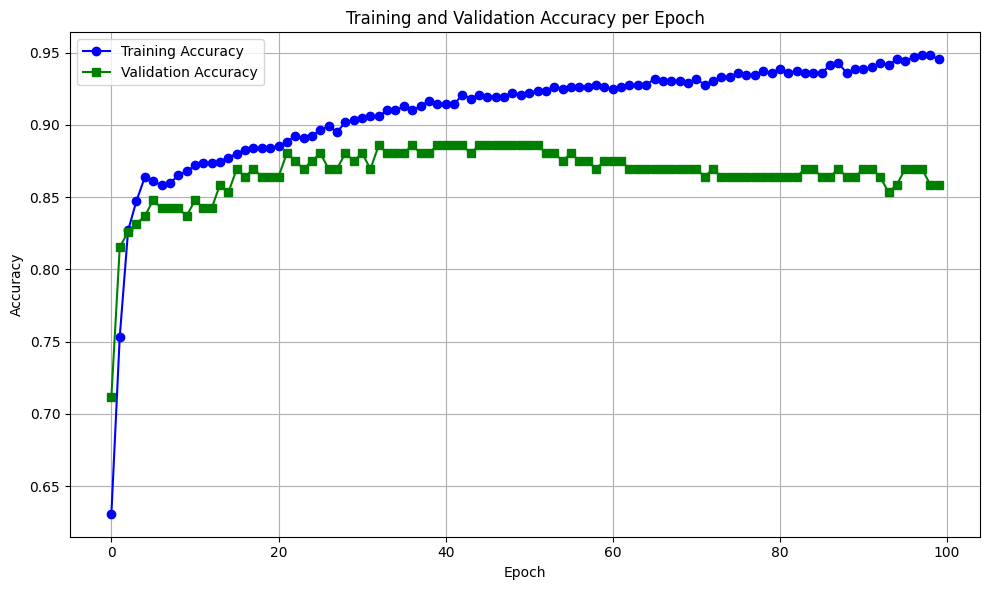

In [27]:
import matplotlib.pyplot as plt
val_acc = history.history['val_accuracy']  # Assuming the metric is named 'val_accuracy'
plt.figure(figsize=(10, 6))

# Plot training accuracy
plt.plot(range(len(history.history['accuracy'])), history.history['accuracy'], label='Training Accuracy', marker='o', color='b')

# Plot validation accuracy
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy', marker='s', color='g')

# Add labels, title, legend, grid, etc.
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

As observed from the graph above, the model has performed exceptionally well on the new dataset. Instead of the accuracies of the training set and validation set diverging by a large margin, both of the accuracies improved per epoch. While the model slightly overfits to the training set, it has generalised well to the validation set with an accuracy of almost 90%

# Optimising the new model using Genetic Algorithm
Like we did in our second approach, we are going to try to optimise this model using Genetic Algorithm by trying to find the optimum number of neurons per layer. In future practice, we can use genetic algorithm to tune the other hyperparameters as well.

In [28]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from deap import base, creator, tools

# Define evaluation function
def evaluate(individual):
    # Decode the individual to obtain the architecture
    n_neurons_hidden1, n_neurons_hidden2, n_neurons_hidden3 = individual
    # Construct the neural network
    model = Sequential([
        tf.keras.Input(shape=(n_new,), name="input_layer"),
        Dense(units=n_neurons_hidden1, activation="relu", name="hidden_layer1"),
        Dense(units=n_neurons_hidden2, activation="relu", name="hidden_layer2"),
        Dense(units=n_neurons_hidden3, activation="relu", name="hidden_layer3"),
        Dense(units=1, activation="sigmoid", name="output_layer"),
    ])
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.01), loss="binary_crossentropy", metrics=['accuracy'])
    # Train the model
    history = model.fit(x_train_new, y_train_new, batch_size=128, epochs=50, validation_data=(x_test_new, y_test_new), verbose=0)
    # Evaluate the model
    loss, accuracy = model.evaluate(x_test_new, y_test_new, verbose=0)
    # Return negative accuracy as fitness (maximization problem)
    return accuracy,

# Define genetic algorithm parameters
POP_SIZE = 8
NUM_GENERATIONS = 3
CROSSOVER_PROB = 1.0
MUTATION_PROB = 0.2

# Create a toolbox for the genetic algorithm
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)
toolbox = base.Toolbox()
toolbox.register("attr_int", np.random.randint, low=1, high=100)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, n=3)  # 3 parameters for the number of neurons in each hidden layer
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=1, up=100, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Generate initial population
population = toolbox.population(n=POP_SIZE)

# Run the genetic algorithm
for gen in range(NUM_GENERATIONS):
    print("Generation", gen + 1)

    # Evaluate the fitness of the population
    fitnesses = list(map(toolbox.evaluate, population))
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit

    # Print the parents' values and fitness values
    print("Parents:")
    for ind in population:
        print("Individual:", ind, "Fitness:", ind.fitness.values[0])

    # Select parents for reproduction
    offspring = toolbox.select(population, len(population))
    offspring = list(map(toolbox.clone, offspring))

    # Apply crossover and mutation
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if np.random.rand() < CROSSOVER_PROB:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if np.random.rand() < MUTATION_PROB:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Print the children's values
    print("Children:")
    for ind in offspring:
        print("Individual:", ind)

    # Replace the population with the offspring
    population[:] = offspring

# Get the best individual
best_individual = tools.selBest(population, k=1)[0]
print("Best individual:", best_individual)


/opt/conda/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/opt/conda/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Generation 1
Parents:
Individual: [33, 62, 81] Fitness: 0.804347813129425
Individual: [63, 50, 53] Fitness: 0.8695651888847351
Individual: [51, 20, 60] Fitness: 0.8478260636329651
Individual: [42, 34, 8] Fitness: 0.842391312122345
Individual: [9, 76, 3] Fitness: 0.8152173757553101
Individual: [4, 64, 3] Fitness: 0.8695651888847351
Individual: [15, 23, 89] Fitness: 0.804347813129425
Individual: [29, 1, 41] Fitness: 0.8097826242446899
Children:
Individual: [63, 1, 53]
Individual: [29, 50, 41]
Individual: [4, 20, 3]
Individual: [51, 64, 60]
Individual: [63, 50, 60]
Individual: [51, 20, 53]
Individual: [63, 50, 3]
Individual: [4, 64, 53]
Generation 2
Parents:
Individual: [63, 1, 53] Fitness: 0.8586956262588501
Individual: [29, 50, 41] Fitness: 0.8586956262588501
Individual: [4, 20, 3] Fitness: 0.864130437374115
Individual: [51, 64, 60] Fitness: 0.85326087474823
Individual: [63, 50, 60] Fitness: 0.8369565010070801
Individual: [51, 20, 53] Fitness: 0.8478260636329651
Individual: [63, 50, 3] 

As we can see from training the model with this new dataset, the model performs much better. Both the validation and training accuracy increase per epoch. However, after about 40 epochs, the model starts overfitting to the training data and thus the validation and training accuracy starts diverging. This was trained only for 100 epochs and yet it performed better, so from this we can conclude that the model failed to learn the patterns from the previous dataset is because the dataset is of low quality. The genetic algorithm is likely to improve the model a lot more if a it is run for more generations with a bigger population size and more hyperparameters are tested.

# Training the Neural Network coded from scratch on the new dataset
We've seen our tensorflow model perform much better on the new dataset. Now we will see how our neural network used in the first approach performs.

Cost after iteration 0: 0.693147214548188
Cost after iteration 100: 0.6914567664160254
Cost after iteration 200: 0.6904319656431439
Cost after iteration 300: 0.689810436168662
Cost after iteration 400: 0.6894332885060412
Cost after iteration 500: 0.6892043143089308
Cost after iteration 600: 0.6890652336045588
Cost after iteration 700: 0.6889807202461612
Cost after iteration 800: 0.6889293473949845
Cost after iteration 900: 0.6888981105688945
Cost after iteration 1000: 0.6888791127032516
Cost after iteration 1100: 0.6888675561291318
Cost after iteration 1200: 0.6888605249445937
Cost after iteration 1300: 0.6888562463840541
Cost after iteration 1400: 0.6888536423801755
Cost after iteration 1500: 0.6888520572300743
Cost after iteration 1600: 0.6888510920706812
Cost after iteration 1700: 0.6888505041682214
Cost after iteration 1800: 0.6888501458461407
Cost after iteration 1900: 0.6888499272704893
Cost after iteration 1999: 0.6888497947752762


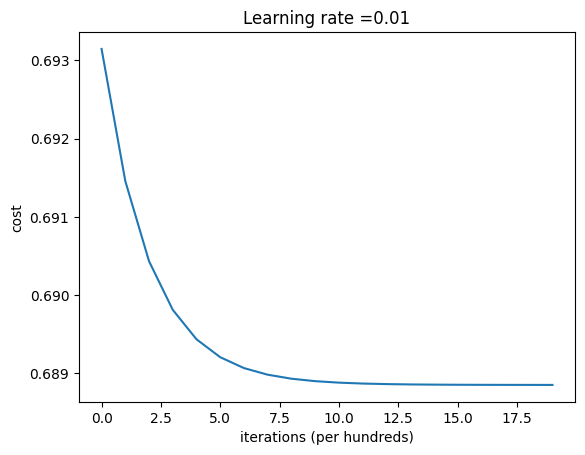

In [29]:
### Layers ###
layers_dims_new = [20, 32, 16, 8, 1] #Specify the number of neurons in each layer
#Train the model
parameters_new, costs_new = L_layer_model(x_train_new.T, y_train_new.T, layers_dims_new, num_iterations = 2000, print_cost = True, learning_rate=0.01)
#Plot the graph of cost against iteration
plot_costs(costs_new, learning_rate=0.01)

As we can see from the results, the cost tapers off and stops decreasing after some iterations. This is most likely because of a gradient vanishing problem where the gradient descent is stuck in a local minima. Since we did not use any optimisation such as momentum for this network, the model is not escaping the local minima. It is possible that if we run the model for a lot more iterations, it will be able to break out from this local minimum and fall into the global basin.

In [30]:
#predicting on the train set
predictions_train_new = predict(x_train_new.T, y_train_new.T, parameters_new)
#predicting on the test set
predictions_test_new = predict(x_test_new.T, y_test_new.T, parameters_new)

Accuracy: 0.5463215258855586
Accuracy: 0.5815217391304348


As the model is stuck in a local minima, the accuracy of the model is quite low.